## NLP Project 13: Metaphor detection in poetry

Danila Goncharenko, 2303788

Ana Ferreira, 2308587

Mikhail Bichagov, 2304806

### This project explores the detection of metaphors in poetry using natural language processing, aiming to distinguish figurative and non-figurative language. 

We shall consider the common use of a phrase as literal use and its violation as an indicative of metaphorical use. The project initially attempts to imitate the approach of Neuman et al. (2013) published in PlusOne journal -Metaphor Identification in Large Texts Corpora- available online [`Metaphor Identification in Large Texts Corpora (plos.org)`](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0062343). So first consider the British national corpus (BNCCorpus), available through NLTK (see also [`British National Corpus, XML edition (ox.ac.uk)`](https://ota.bodleian.ox.ac.uk/repository/xmlui/handle/20.500.12024/2554)). For testing, we shall consider the annotated corpus available at https://www.eecs.uottawa.ca/~diana/resources/metaphor/type1_metaphor_annotated.txt 

In the above, the annotation at the end of the sentence i.e., @1@y   indicates whether it is a metaphor (y) or not (n). Here the presence of ‘y’ indicates that it is a metaphor, whereas “1” indicates the first head word of the sentence, which is “poise”, in the part of speech tag sequence. 


In [2]:
# Imports
import nltk
import pandas as pd
from nltk.corpus import stopwords, CategorizedPlaintextCorpusReader
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist, bigrams
from itertools import chain

from nltk.collocations import *

# Downloading the BNC corpus and stopwords
nltk.download('stopwords')

# Stopwords, Lemmatizer, Bi-gram
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
bigram_measures = nltk.collocations.BigramAssocMeasures()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jklbichami\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Task 1

First, we shall consider the mutual information, see expression (2) in Neuman et al.’2003 paper, as a guideline to derive the metaphor-reasoning.  You can inspire from other available implementations of mutual information, in [`Collocations (nltk.org)`](https://www.nltk.org/howto/collocations.html), [`FNLP 2011: Tutorial 8: Working with corpora: mutual information (ed.ac.uk)`](http://www.inf.ed.ac.uk/teaching/courses/fnlp/lectures/8/tutorial.html). Consider the words “woman”, “use”, “dream”, “body”. Write a program that identifies all adjectives, adverbs and verbs that occur within 2 lexical units (span = 2 in the formula of mutual information) in BNC corpus and whose mutual information is equal or greater than 3, considered as the minimum statistical significance. Suggest appropriate adjustments (e.g., greater span) if no results are found to match the mutual information criterion.

### Convert text from BNC corpus to unigrams and bigrams

Below commented out code can be used if you'd like to regenerate uni and bi-grams and export then to json files

In [2]:
#### ATTENTION: RUNNING THIS PART REQUIRES TO HAVE ZIPPED BNC DOWNLOADED
#### ALL BIGRAM AND 1-GRAM INFORRMATION IS STORED IN JSON FILES FOR FASTER READING IN FUTURE
#### Comment out if you would like to run it and export to json files yourself

# import nltk
# from nltk.corpus.reader.bnc import BNCCorpusReader
# from nltk import FreqDist, bigrams
# from itertools import chain
# from nltk.corpus import stopwords
# from nltk.collocations import *
# nltk.download('stopwords')
# import zipfile
# import json
# 
# 
# corpus = []
# 
# BCN corpus in zip
# zip_file_path = r'C:\Users\jklbichami\OneDrive - Valmet\Documents\School\Porgramming\NLP\Metaphor-detection-in-poetry\2553.zip'
# 
# bnc_reader = BNCCorpusReader(root=zip_file_path, fileids=r'[A-K]//w*//w*/.xml')
# 
# Iterating through the zip folder and retriving text from each file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # List the files and folders in the zip archive
    # file_list = zip_ref.namelist()
# 
    # for item in file_list:
        # if 'download/Texts/' in item and item.endswith('.xml'):
            # folder_name = item.rstrip('/')  # Extract folder name
            # corpus.append(bnc_reader.sents(folder_name))
# 
# bigram_measures = nltk.collocations.BigramAssocMeasures()
# 
# words_to_include = ['woman', 'use', 'dream', 'body']
# 
# Get the words from the file in list format
# es = stopwords.words('english')
# 
# g = FreqDist(bigrams(w.lower() for doc in corpus for sent in doc for w in sent if (w.isalpha() and w.lower() not in es)))
# 
# 
# Additional function to load data to json file, as json library does not allow to have tuple as key
# def remap_keys(mapping):
    # return [{'key':k, 'value': v} for k, v in mapping.items()]
# 
# Saving data to json files for future faster reading
# with open('bigram_bnc.json', 'w') as fp:
    # json.dump(remap_keys(g), fp)
# f = FreqDist()
# for k in g.keys():
    # if k[1] in words_to_include or k[0] in words_to_include:
        # f[k] = g.get(k)

# u = FreqDist(w.lower() for w in chain.from_iterable(chain.from_iterable(corpus)) if (w.isalpha() and not(w.lower() in es)))
# 
# 
# with open('unigram_bnc.json', 'w') as fu:
    # json.dump(u, fu)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jklbichami\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loading data from json files generated with above code

In [3]:
import json

## Reading bigram data from json file
with open('all_bigrams_bnc.json', 'r') as json_file:
    bigram_data_origin = json.load(json_file)

bigram_data = {}
for i in bigram_data_origin:
    bigram_data[tuple(i['key'])] = i['value']

## Reading unigram data from json file
with open('unigram_bnc.json', 'r') as json_file:
    unigram_frequency_all = json.load(json_file)

## Converting dict to FreqDist for futher use
# bigram_data = FreqDist(bigram_data)
# unigram_frequency = FreqDist(unigram_frequency)

### Expression (2) in Neuman et al.’2013 paper

In [8]:
# See expression (2) in Neuman et al.’2013 paper
import math
def Mutual_information(bigram_item, filteredCorpus, Corpus, span = 2):    
    '''
    Calculates Mutual information between node and collocate words
    bigram_item = The bigram which is considered in the equation
    filteredCorpus = The corpus with only considered words.
    Corpus = The whole corpus.
    span = span of words
    '''

    # filteredCorpus[fr_B_near_A] = frequency of collocate near the node word (e.g., color near purple)
    # Corpus.N() = size of the corpus (for instance 96,263,399, BNC)
    # Corpus[p[0]] = frequency of node word w1 (e.g., purple): 1262
    # Corpus[p[1]] = frequency of collocate word w2 (e.g., color): 115
    # span = span of words (e.g., 1 to left and 1 to right of the node word: 2)

    #sizeCorpus = 96 132 981 tokens in BNC

    try:
        return math.log10((filteredCorpus[bigram_item] * Corpus.N()) / (Corpus[bigram_item[0]] * Corpus[bigram_item[1]] * span))/math.log10(2)
    except:
        return 

### Calculate Mutual information frequency

In [70]:

import nltk
from nltk import FreqDist, bigrams
from nltk.corpus import stopwords
from nltk.collocations import *
nltk.download('stopwords')


# Consider the words “woman”, “use”, “dream”, “body”.
words_to_include = ['woman', 'use', 'dream', 'body']

# Calculate the frequency of bigrams of the words to include that are in the corpus
fr_words_to_include = FreqDist()
for key_word in bigram_data.keys():
    # If first or second word in bigram, e.g. ('woman', 'receiving'), has a word_to_include
    # Pass the frequency of this bigram from bigram_data to fr_words_to_include
    if key_word[1] in words_to_include or key_word[0] in words_to_include:
        fr_words_to_include[key_word] = bigram_data.get(key_word)

# Identify all adjectives, adverbs and verbs that occur within 2 lexical units (span = 2 in the formula of mutual information) in BNC corpus
# Mutual information frequency
fmi = {}
for p in fr_words_to_include.keys():
    fmi[p]  = Mutual_information(p, fr_words_to_include, FreqDist(unigram_frequency_all))

# Mutual information is equal or greater than 3, considered as the minimum statistical significance
fmi = {key: value for key, value in fmi.items() if value > 3}

dict(sorted(fmi.items(), key=lambda item: item[1], reverse=True))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jklbichami\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{('dream', 'unmetaphorical'): 12.428855736155493,
 ('disarmer', 'dream'): 12.428855736155493,
 ('dream', 'cowps'): 12.428855736155493,
 ('chocaholic', 'dream'): 12.428855736155493,
 ('fuzzweed', 'dream'): 12.428855736155493,
 ('dream', 'lovenest'): 12.428855736155493,
 ('dazzlers', 'dream'): 12.428855736155493,
 ('adeyfield', 'dream'): 12.428855736155493,
 ('finster', 'dream'): 12.428855736155493,
 ('dream', 'yoshikuni'): 12.428855736155493,
 ('counterproof', 'dream'): 12.428855736155493,
 ('dream', 'heeeeeeevvv'): 12.428855736155493,
 ('fellwalker', 'dream'): 12.428855736155493,
 ('ovaloid', 'dream'): 12.428855736155493,
 ('sweetnesses', 'dream'): 12.428855736155493,
 ('dream', 'jouvence'): 12.428855736155493,
 ('dream', 'teillard'): 12.428855736155493,
 ('dream', 'macsen'): 12.428855736155493,
 ('navarkhon', 'dream'): 12.428855736155493,
 ('dream', 'bapputchin'): 12.428855736155493,
 ('dream', 'woek'): 12.428855736155493,
 ('entrepenur', 'dream'): 12.428855736155493,
 ('reoccuring', 

### Suggest appropriate adjustments (e.g., greater span), if no results

In [ ]:
# Suggest appropriate adjustments (e.g., greater span), if no results

## Task 2

We would like to test this process in the previous metaphor annotated dataset. For this purpose, consider the following approach. Write a program that inputs each sentence of the annotated corpus, and then reads the head word (given in the annotation), then calculate the mutual distance between the head-word and each of the first two words occurring either on the left hand side part or right hand side part of the head-word. If the average of mutual distances from head word to each of the two words situated at two lexical units is greater than 3, then we shall consider the sentence is not a metaphor, otherwise, it is a metaphor. Test this reasoning and report the result for each annotated sentence and save it in your database. Given the ground truth of the annotated dataset, calculate the corresponding accuracy, and comment on the efficiency of the proposed approach.

In [61]:
import re
import pandas as pd
import numpy as np
import math

url = "https://www.eecs.uottawa.ca/~diana/resources/metaphor/type1_metaphor_annotated.txt"

# this file is the downloaded text of the content of the above url
file = 'type1_metaphor_annotated.txt'


with open(file, 'r') as file:
    # Read the contents of the file
    file_contents = file.read()

lines = file_contents.split('\n')
data = [line.split('\t') for line in lines if line]

df = pd.DataFrame(data, columns = ['Text'])


# Extract the symbol ('y', 'n' or 's') and number into separate columns
df['Symbol'] = df['Text'].str.extract(r'@(\d+)@([yns])')[1] # add the s
df['Number'] = df['Text'].str.extract(r'@(\d+)@([yns])')[0]

# Take away the 's' symbol because it means skipped sentence and we only
# want the 'y' or 'n' symbols which tell us if the text is a metaphor or not

df = df[df['Symbol'] != 's']

# Reset the index
df.reset_index(drop=True, inplace=True)

# Delete it from the original text
df['Text'] = df['Text'].str.replace(r'(@\d+@y|@\d+@n)', '', regex=True)

# Replace NaN values in 'Number' with 0, and then convert to integer
df['Number'] = df['Number'].fillna(0).astype(int)

# Extract the word with the specified index and save it in the 'Head-word' column
df['Head-word'] = df.apply(lambda row: row['Text'].split()[int(row['Number']) - 1], axis=1)

# check if the symbols in the 'Symbol' column are only either 'y' or 'n'

unique_symbols = df['Symbol'].unique()

unique_symbols_list = list(unique_symbols)

# Display the resulting DataFrame
df

,Text,Symbol,Number,Head-word
0,poise is a club .,y,1,poise
1,destroying alexandria . sunlight is silence,y,4,sunlight
2,feet are no anchor . gravity sucks at the mind,y,1,feet
3,on the day 's horizon is a gesture of earth,y,5,horizon
4,he said good-by as if good-by is a number .,y,6,good-by
...,...,...,...,...
675,as the season of cold is the season of darkness,n,5,cold
676,"else all beasts were tigers ,",y,3,beasts
677,without which earth is sand,n,3,earth
678,the sky is cloud on cloud,n,2,sky


### Extract content

In [11]:
# this function basically takes each sentence from the column 'Text', each head word index from the column 'Head-word'
# and the window_size (2, because we want to see two words left and right from the head word (it is not the same concept as span))

# this function was made because the index of the head word takes into account elements of the string that are puntuaction
# (for example: '-- the others were the despots of despair -- @3@y' in this sentence the character -- is taken into account
# in the count of the head word (others) index)
# because of this, this function evaluates which words contain at least one letter and are not stopwords, returns a boolean
# and saves the indexes that fulfill these conditions in the sentence to a variable called 'found_indices'
# then it finds the index in the list of the sentences indexes which the value is equal to the head word index ('target_index')
# after that it extracts the 2 indexes of the words to the left and to the right of the head word that are in 'found_indices'
# then it slices 'found_indices' to extract a window with span = 4 (like it says in the 2nd assessment)
# after that it uses the numpy array function to extract the words from the vector 'words' in the same indexes as the list 'indeces'
# and put them in the variable 'selected_elements' which is returned by the function to the caller

# this function is called to each row of the column 'Text' in the dataframe 'df'

import nltk
from nltk.corpus.reader.bnc import BNCCorpusReader
from nltk import FreqDist, bigrams
from itertools import chain
from nltk.collocations import *
import zipfile
import json
import re

def extract_context(text, target_index, window_size):
    # split the text list into words
    words = text.split()
    # Use a list comprehension to check if each element contains at least a letter (some words have a hyphen like good-by)
    # and if the words are not in stopwords
    # the result is a boolean vector that represents which words in the vector satisfy the conditions
    contains_words = [bool(re.search(r'[a-zA-Z]', word)) and word not in stop_words and not re.match(r'^[^a-zA-Z]*s[^a-zA-Z]*$', word) for word in words]

    # Find all the 'True' occurrences using vectorized operations
    # Get the indices of those ocurrences in the words list
    found_indices = np.where(contains_words)[0]

    # if nothing is found return an empty list
    if found_indices.size == 0:
        return []
        
    # Get the index in the found_indices list of the head word index in the words list
    index = np.where(found_indices == target_index)[0][0]

    # make sure that the index two places to the left from found_indices that corresponds to the head word index in the words list is not out of bounds
    start = max(0, index - window_size)
    # make sure that the index two places to the right from found_indices that corresponds to the head word index in the words list is not out of bounds
    end = min(len(found_indices), index + window_size + 1)

    # slice the found_indices list to get the desired span (in this case 4 which means that the window is 2)
    indeces = found_indices[start:end]

    # Access elements in the list words which their corresponding indexes are in the list indeces, using the NumPy array function
    selected_elements = np.array(words)[indeces]
    
    return selected_elements

### Filter the annotated text, put sentences from filtered Text into a list with tokens, create bigrams from the list

In [12]:
# Use the apply method to extract the head-word and each of the first two words
# either on the left hand side part or right hand side part of the head-word

# this expression calls the function extract_context for every row in the df dataframe
list_of_lists = df.apply(lambda row: extract_context(row['Text'], int(row['Number']) - 1, 2), axis=1)

# take away every element in every sublist of list_of_lists that does not have at least one letter or a hyphen (some words are hyphenated)
list_of_lists = [[re.sub(r'[^a-zA-Z-]', '', word) for word in sublist] for sublist in list_of_lists]

# eliminate every element in every sublist of list_of_lists that is an empty string
list_of_lists = [[word for word in sublist if word != ''] for sublist in list_of_lists]

# get a single list of all the bigrams in the list_of_lists, which is a list that contains a list for every row in
# the df dataframe with the words in the desired span (in this case 4)
# it is also worth noting that sometimes the span is not 4 because there were not enough words to the right or to the left of the head word
bigrams_interest = [bigram for sublist in list_of_lists for bigram in list(bigrams(sublist))]

# list that contains a list for of the bigrams for every row
# it is added to the column 'Bigrams'
df['Bigrams'] = [list(bigrams(sublist)) for sublist in list_of_lists]


print(list_of_lists)
print(bigrams_interest)


[['poise', 'club'], ['destroying', 'alexandria', 'sunlight', 'silence'], ['feet', 'anchor', 'gravity'], ['day', 'horizon', 'gesture', 'earth'], ['said', 'good-by', 'good-by', 'number'], ['although', 'eyes', 'lakes', 'dies'], ['ways', 'world', 'taxi', 'enter'], ['poet', 'man', 'feigns'], ['man', 'animal', 'needs'], ['name', 'james', 'wright'], ['earth', 'door', 'cannot'], ['hackles', 'neck', 'fear', 'grief'], ['moon', 'sow'], ['earth', 'birth', 'blues'], ['nature', 'understanding', 'one', 'simple'], ['real', 'terror', 'nature', 'humanity', 'enraged'], ['love', 'word', 'another'], ['goodbye', 'promise', 'lightning'], ['broken', 'body', 'afterimage', 'st'], ['eyes', 'caves', 'chunks'], ['sky', 'baby', 'blue'], ['road', 'somebody', 'small'], ['wrote', 'life', 'strain', 'later'], ['clear', 'mr', 'haggard', 'ryder', 'brother'], ['mind', 'city', 'like'], ['others', 'despots', 'despair'], ['intuitively', 'sense', 'humor', 'necessity'], ['guilt', 'nameless', 'name', 'time'], ['name', 'death', '

### Put all unfiltered sentences from Text into a list with tokens

In [13]:
# list that contains a list for every row with the words of the column 'Text'
word_lists = [text.split() for text in df['Text']]

# take away every element in every sublist of word_lists that does not have at least one letter or a hyphen (some words are hyphenated)
word_lists = [[re.sub(r'[^a-zA-Z-]', '', word) for word in sublist] for sublist in word_lists]

# eliminate every element in every sublist of word_lists that is an empty string
word_lists = [[word for word in sublist if word != ''] for sublist in word_lists]

print(word_lists)

[['poise', 'is', 'a', 'club'], ['destroying', 'alexandria', 'sunlight', 'is', 'silence'], ['feet', 'are', 'no', 'anchor', 'gravity', 'sucks', 'at', 'the', 'mind'], ['on', 'the', 'day', 's', 'horizon', 'is', 'a', 'gesture', 'of', 'earth'], ['he', 'said', 'good-by', 'as', 'if', 'good-by', 'is', 'a', 'number'], ['although', 'your', 'eyes', 'be', 'lakes', 'dies'], ['ways', 'as', 'if', 'the', 'world', 'were', 'a', 'taxi', 'you', 'enter', 'it', 'then'], ['the', 'poet', 'is', 'a', 'man', 'who', 'feigns'], ['man', 'is', 'an', 'animal', 'that', 'needs', 'a', 'warden'], ['my', 'name', 'is', 'james', 'a', 'wright', 'and', 'i', 'was', 'born'], ['earth', 'is', 'a', 'door', 'i', 'cannot', 'even', 'face'], ['the', 'hackles', 'on', 'my', 'neck', 'are', 'fear', 'not', 'grief'], ['the', 'moon', 'is', 'a', 'sow'], ['earth', 'is', 'the', 'birth', 'of', 'the', 'blues', 'sang', 'yellow', 'bertha'], ['about', 'the', 'nature', 'of', 'understanding', 'no', 'one', 'is', 'that', 'simple'], ['the', 'real', 'terro

### Every bigram without stopwords in every unfiltered sentence from Text

In [14]:
# creates a single list with every bigram in every sentence of the annotated corpus
# it also selects the words that contain at least a letter and are not stop_words
bigrams_lists = [bigram for sublist in word_lists for bigram in list(bigrams(w.lower() for w in sublist if (re.match(r'[a-zA-Z]', w) and w.lower() not in stop_words)))]

# transform word_lists into a single list
words = list(chain.from_iterable(word_lists))

print(bigrams_lists)

[('poise', 'club'), ('destroying', 'alexandria'), ('alexandria', 'sunlight'), ('sunlight', 'silence'), ('feet', 'anchor'), ('anchor', 'gravity'), ('gravity', 'sucks'), ('sucks', 'mind'), ('day', 'horizon'), ('horizon', 'gesture'), ('gesture', 'earth'), ('said', 'good-by'), ('good-by', 'good-by'), ('good-by', 'number'), ('although', 'eyes'), ('eyes', 'lakes'), ('lakes', 'dies'), ('ways', 'world'), ('world', 'taxi'), ('taxi', 'enter'), ('poet', 'man'), ('man', 'feigns'), ('man', 'animal'), ('animal', 'needs'), ('needs', 'warden'), ('name', 'james'), ('james', 'wright'), ('wright', 'born'), ('earth', 'door'), ('door', 'cannot'), ('cannot', 'even'), ('even', 'face'), ('hackles', 'neck'), ('neck', 'fear'), ('fear', 'grief'), ('moon', 'sow'), ('earth', 'birth'), ('birth', 'blues'), ('blues', 'sang'), ('sang', 'yellow'), ('yellow', 'bertha'), ('nature', 'understanding'), ('understanding', 'one'), ('one', 'simple'), ('real', 'terror'), ('terror', 'nature'), ('nature', 'humanity'), ('humanity',

### Mutual information of every bigram

In [15]:
bigram_frequency = FreqDist(bigrams_lists)

# Calculate the frequency of bigrams of the words in the pre-defined window

frequencies_of_interest = {bigram: bigram_frequency[bigram] for bigram in bigrams_interest}

# print(frequencies_of_interest)

# Frequency of all words in the annotation

unigram_frequency = FreqDist(w.lower() for w in words if (re.match(r'[a-zA-Z]', w) and w.lower() not in stop_words))

# Calculate the mutual distance

# See expression (2) in Neuman et al.’2013 paper

def Mutual_information(bigram_item, filteredCorpus, Corpus, span = 2):    
    '''
    Calculates Mutual information between node and collocate words
    bigram_item = The bigram which is considered in the equation
    filteredCorpus = The corpus with only considered words.
    Corpus = The whole corpus.
    span = span of words
    '''

    try:
        return math.log10((filteredCorpus[bigram_item] * Corpus.N()) / (Corpus[bigram_item[0]] * Corpus[bigram_item[1]] * span))/math.log10(2)
    except:
        return

# calculate mutual information for each of the bigrams in the desired span in each sentence of the annotated corpus
fmi = {bigram: Mutual_information(bigram, frequencies_of_interest, unigram_frequency, span = 4) for bigram in bigrams_interest}

print(fmi)

{('poise', 'club'): 9.560810468727942, ('destroying', 'alexandria'): 9.560810468727942, ('alexandria', 'sunlight'): 8.56081046872794, ('sunlight', 'silence'): 6.560810468727941, ('feet', 'anchor'): 6.560810468727941, ('anchor', 'gravity'): 8.56081046872794, ('day', 'horizon'): 5.390885467285629, ('horizon', 'gesture'): 8.56081046872794, ('gesture', 'earth'): 6.101378850090644, ('said', 'good-by'): 5.238882373840578, ('good-by', 'good-by'): 7.560810468727941, ('good-by', 'number'): 8.56081046872794, ('although', 'eyes'): 6.753455546670336, ('eyes', 'lakes'): 5.753455546670336, ('lakes', 'dies'): 8.56081046872794, ('ways', 'world'): 4.275408249865692, ('world', 'taxi'): 5.860370750586849, ('taxi', 'enter'): 9.560810468727942, ('poet', 'man'): 3.6066141583410656, ('man', 'feigns'): 4.606614158341066, ('man', 'animal'): 4.606614158341066, ('animal', 'needs'): 9.560810468727942, ('name', 'james'): 5.390885467285629, ('james', 'wright'): 9.560810468727942, ('earth', 'door'): 4.51641634936948

### Mutual distance of every bigram

In [16]:
# eliminate the elements that had value equal to 'None'
fmi = {key: value for key, value in fmi.items() if value is not None}

# find the key which has the maximum value
max_key = max(fmi, key=fmi.get)

# find the maximum value
# this value will be the constant K in the formula given by the professor:
# distance (S1, S2) = K – Mutual_Information (S1, S2)
# this way the distance will be the lowest to the bigram with the highest mutual information value and we avoid having negative values
max_value = fmi[max_key]

#print(max_value)
# calculate the distance between every bigram in the desired span using the values in the dictionary fmi
# formula is written above
mutual_distance = {key: max_value - value for key, value in fmi.items()}

#print({key: value for key, value in mutual_distance.items() if value <= 3})

# Report the result for each annotated sentence
# If average is greater than 3, sentence is not a metaphor, so we will choose only the bigrams that indicate the presence of a metaphor
metaphor_mutual_distance = {key: value for key, value in mutual_distance.items() if value <= 3}

# Save it in your database


### Find metaphors

In [17]:
# Create a function to see if the bigrams in the keys of the dictionary metaphor_mutual_distance are
# in the bigrams associated to each sentence in the df dataframe
# if the bigrams associated to the current sentence in analysis are in the dictionary metaphor_mutual_distance,
# the return value is 'y' to simbolize a metaphor, otherwise it is 'n'
def find_metaphor(bigrams, metaphor):
    m = [bigram for bigram in bigrams if bigram in metaphor]
    if m == []:
        return 'n'
    else:
        return 'y'

In [18]:
# Apply the function to every row of the 'Bigrams' column
df['Metaphor'] = df.apply(lambda row: find_metaphor(row['Bigrams'], metaphor_mutual_distance), axis=1)

# Calculate the corresponding accuracy

# calculate True Positives
TP = (df['Symbol'] == 'y') & (df['Metaphor'] == 'y')
TP = TP.sum()

# calculate True Negatives
TN = (df['Symbol'] == 'n') & (df['Metaphor'] == 'n')
TN = TN.sum()


# calculate False Positives
FP = (df['Symbol'] == 'n') & (df['Metaphor'] == 'y')
FP = FP.sum()

# calculate False Negatives
FN = (df['Symbol'] == 'y') & (df['Metaphor'] == 'n')
FN = FN.sum()


# accuracy = correctly classified instances / all instances
accuracy = (TP + TN) / df.shape[0]
formatted_accuracy = "{:.2f}%".format(accuracy * 100)

print('Accuracy:', formatted_accuracy)

# Comment on the efficiency of the proposed approach.
print('The efficiency is not that great since we only got, approximately, half of the predictions correct.')

Accuracy: 56.62%
The efficiency is not that great since we only got, approximately, half of the predictions correct.


## Task 3

We consider the (adjective-noun) type of metaphor (referred to as Metaphor type III). A metaphor  assumes to occur when the categories of noun and adjective are such that one is concrete and the other one is abstract. WordStat noun categorization based on WordNet, which classifies 69,817 nouns into 25 categories, of which 13 are concrete categories (e.g., artifact) provides a database for a such categorization. It is freely available in [`Wordnet based categorization dictionary - Provalis Research`](https://provalisresearch.com/products/content-analysis-software/wordstat-dictionary/wordnet-based-categorization-dictionary/). Write a program that allows you to retrieve the category of noun and adjective / adverb in a sentence according to WordStat.

In [4]:
import re

file_p = 'WordNet Words & Phrases.CAT'

with open(file_p, 'r') as file:
    cat_data = file.readlines()

pattern = r'\.(.+)'

noun_categories = [re.search(pattern, a).group(1).strip('\n') for a in cat_data if '\t\t' not in a and a.startswith('\tNOUN.')]
noun_categories_idices = [cat_data.index('\tNOUN.' + a + '\n') for a in noun_categories]

verb_categories = [re.search(pattern, a).group(1).strip('\n') for a in cat_data if '\t\t' not in a and a.startswith('\tVERB.')]
verb_categories_idices = [cat_data.index('\tVERB.' + a + '\n') for a in verb_categories]

adj_categories = [re.search(pattern, a).group(1).strip('\n') for a in cat_data if '\t\t' not in a and a.startswith('\tADJ.')]
adj_categories_idices = [cat_data.index('\tADJ.' + a + '\n') for a in adj_categories]

cat_df = pd.DataFrame(columns=['Type', 'Category', 'Word'])


## Idea is to store pos categories and their indeces
## Iterate through each category indeces and create df based on it

## NOUN
for indx, num in enumerate(noun_categories_idices):
    temp_dict = {}
    if indx == 0:
        temp_dict['Category'] = [noun_categories[indx]]*abs(cat_data.index('NOUNS\n')+1-noun_categories_idices[indx+1]+1)
        temp_dict['Type'] = ['Noun']*abs(cat_data.index('NOUNS\n')+1-noun_categories_idices[indx+1]+1)
        temp_dict['Word'] = [a[2:].strip(' (1)\n)').lower() for a in  cat_data[cat_data.index('NOUNS\n')+2:noun_categories_idices[indx+1]]]
        cat_df = pd.concat([cat_df, pd.DataFrame(temp_dict)], ignore_index=True)
    else:
        try:
            temp_dict['Category'] = [noun_categories[indx]]*abs(noun_categories_idices[indx]+1-noun_categories_idices[indx+1])
            temp_dict['Type'] = ['Noun']*abs(noun_categories_idices[indx]+1-noun_categories_idices[indx+1])
            temp_dict['Word'] = [a[2:].strip(' (1)\n)').lower() for a in  cat_data[noun_categories_idices[indx]+1:noun_categories_idices[indx+1]]]
            cat_df = pd.concat([cat_df, pd.DataFrame(temp_dict)], ignore_index=True)
        except IndexError:
            pass

## VERB
for indx, num in enumerate(verb_categories):
    temp_dict = {}
    if indx == 0:
        temp_dict['Category'] = [verb_categories[indx]]*abs(cat_data.index('VERBS\n')+1-verb_categories_idices[indx+1]+1)
        temp_dict['Type'] = ['Verb']*abs(cat_data.index('VERBS\n')+1-verb_categories_idices[indx+1]+1)
        temp_dict['Word'] = [a[2:].strip(' (1)\n)').lower() for a in  cat_data[cat_data.index('VERBS\n')+2:verb_categories_idices[indx+1]]]
        cat_df = pd.concat([cat_df, pd.DataFrame(temp_dict)], ignore_index=True)
    else:
        try:
            temp_dict['Category'] = [verb_categories[indx]]*abs(verb_categories_idices[indx]+1-verb_categories_idices[indx+1])
            temp_dict['Type'] = ['Verb']*abs(verb_categories_idices[indx]+1-verb_categories_idices[indx+1])
            temp_dict['Word'] = [a[2:].strip(' (1)\n)').lower() for a in  cat_data[verb_categories_idices[indx]+1:verb_categories_idices[indx+1]]]
            cat_df = pd.concat([cat_df, pd.DataFrame(temp_dict)], ignore_index=True)
        except IndexError:
            pass

## ADJECTIVE
for indx, num in enumerate(adj_categories):
    temp_dict = {}
    if indx == 0:
        temp_dict['Category'] = [adj_categories[indx]]*abs(cat_data.index('ADJECTIVES\n')+1-adj_categories_idices[indx+1]+1)
        temp_dict['Type'] = ['Adjective']*abs(cat_data.index('ADJECTIVES\n')+1-adj_categories_idices[indx+1]+1)
        temp_dict['Word'] = [a[2:].strip(' (1)\n)').lower() for a in  cat_data[cat_data.index('ADJECTIVES\n')+2:adj_categories_idices[indx+1]]]
        cat_df = pd.concat([cat_df, pd.DataFrame(temp_dict)], ignore_index=True)
    else:
        try:
            temp_dict['Category'] = [adj_categories[indx]]*abs(adj_categories_idices[indx]+1-adj_categories_idices[indx+1])
            temp_dict['Type'] = ['Adjective']*abs(adj_categories_idices[indx]+1-adj_categories_idices[indx+1])
            temp_dict['Word'] = [a[2:].strip(' (1)\n)').lower() for a in  cat_data[adj_categories_idices[indx]+1:adj_categories_idices[indx+1]]]
            cat_df = pd.concat([cat_df, pd.DataFrame(temp_dict)], ignore_index=True)
        except IndexError:
            pass

## ADVERB, has no category segregations
temp_dict = {}
temp_dict['Category'] = ['All']*abs(cat_data.index('ADVERBS\n')+2-cat_data.index('NOUNS\n'))
temp_dict['Type'] = ['Adverb']*abs(cat_data.index('ADVERBS\n')+2-cat_data.index('NOUNS\n'))
temp_dict['Word'] = [a[2:].strip(' (1)\n)').lower() for a in  cat_data[cat_data.index('ADVERBS\n')+2:cat_data.index('NOUNS\n')]]
cat_df = pd.concat([cat_df, pd.DataFrame(temp_dict)], ignore_index=True)

print (f"Result df value counts:\n{cat_df['Type'].value_counts()}")

Result df value counts:
Type
Noun         128014
Verb          17938
Adverb         4667
Adjective      4374
Name: count, dtype: int64


In [14]:
# Example of getting pos and topics
from nltk.tokenize import word_tokenize
sent = 'I love exceptional food with green salad'
to = word_tokenize(sent)
[(a, 
list(cat_df['Category'][cat_df['Word'] == a]), 
list(cat_df['Type'][cat_df['Word'] == a])) 
for a in to]


[('I', [], []),
 ('love',
  ['ACT', 'COGNITION', 'FEELING', 'PERSON', 'QUANTITY', 'CONTACT', 'EMOTION'],
  ['Noun', 'Noun', 'Noun', 'Noun', 'Noun', 'Verb', 'Verb']),
 ('exceptional', [], []),
 ('food', ['TOPS', 'COGNITION', 'FOOD'], ['Noun', 'Noun', 'Noun']),
 ('with', [], []),
 ('green',
  ['ARTIFACT',
   'ATTRIBUTE',
   'FOOD',
   'LOCATION',
   'OBJECT',
   'PERSON',
   'CHANGE',
   'PERT'],
  ['Noun', 'Noun', 'Noun', 'Noun', 'Noun', 'Noun', 'Verb', 'Adjective']),
 ('salad', ['FOOD'], ['Noun'])]

## Task 4

Now we would like to imitate the procedure mentioned in Neuman’s paper for type III semaphore. Write a program that identifies the occurrence of Noun-Adjective/Adverb part-of-speech in a given sentence. Then, use WordNet lexical database to find out the number of senses of each adjective. If every adjective has one single sense, then return, no metaphor. If the Noun has no entry in wordnet, then return UNKNOWN. Otherwise (adjective has more than one sense and noun has an entry in WordNet), then identify the set S of nouns in the BNC corpus that collocate with the given Noun of the given sentence (this corresponds to a set of nouns whose mutual information value is greater or equal than 3). Next, for each element (noun) of S, use the WordStat categorization to identify those who belong to concrete class. Let S1 be a subset of S, which contains these “concrete”-category nouns. If the number of elements in S1 is large, then restrict to the first three elements who have the highest mutual information values. Finally, to find out whether, whether the sentence containing adjective A and noun N is a metaphor, we need to test the compatibility of each elements of S1 with N. If there is no elements in S1 compatible with N, then we shall consider S as a metaphor, otherwise, it is not. To evaluate this compatibility, you can use the Wu and Palmer WordNet semantic similarity already implemented in NLTK. Therefore, assume that if the Wu and Palmer semantic similarity of at least of the nouns in S1 with N is greater than a threshold 0.4, then the compatibility between S1 and N is granted. (Note this is only a very rough approximation). Write a code that implements this reasoning and test it on two simple examples of your choice. Test this process for other values of threshold values (e.g., 0.3, 0.5, 0.6) 

Function to find the POS of a sentence and check if there is a Noun-Adverb/Adjective Pair

In [66]:
import spacy


def noun_pairs_adjv(sentence):
    
    # Load a pre-trained spaCy model for part-of-speech tagging (e.g., 'en_core_web_sm' for English)
    nlp = spacy.load('en_core_web_sm')

    doc = nlp(sentence.lower())

    w = [token.text for token in doc if re.match(r'[a-zA-Z]', token.text)]

    pos_tags = [(token.text, token.pos_) for token in doc if token.text not in stop_words and re.match(r'[a-zA-Z]', token.text)]

    #print(pos_tags)

    # Initialize a list to store Noun-Adjective/Adverb pairs
    noun_adj_pairs = []

    # Count number of adjectives
    count_adj = 0

    # Iterate through the tagged words to find Noun-Adjective and Noun-Adverb pairs
    for i in range(len(pos_tags)):
        word, pos = pos_tags[i]

        if pos == 'NOUN':

            if i < (len(pos_tags)-1):
                next_word, next_pos = pos_tags[i + 1]
        
                if (next_pos == 'ADJ' or next_pos == 'ADV') and (word, next_word) not in noun_adj_pairs:
                    noun_adj_pairs.append((word, next_word))
                    if next_pos == 'ADJ':
                        count_adj += 1

            if i > 0:
                prev_word, prev_pos = pos_tags[i - 1]

                if (prev_pos == 'ADJ' or prev_pos == 'ADV') and (word, prev_word) not in noun_adj_pairs:
                    noun_adj_pairs.append((word, prev_word))
                    if prev_pos == 'ADJ':
                        count_adj += 1

    return noun_adj_pairs, count_adj, w

sentence = "The quick brown fox jumps over the lazy dog. The lazy dog barks loudly."
sent = 'He was a rather frightened flower in her presence.'
s = 'season of coldness, season of darkness'

noun_adj_pairs, count_adj, w = noun_pairs_adjv(sentence)

print(w)

print("Noun-Adjective/Adverb Pairs:")
for word1, word2 in noun_adj_pairs:
    print(f"{word1} - {word2}")

print("Number of Adjectives")
print(count_adj)

['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog', 'the', 'lazy', 'dog', 'barks', 'loudly']
Noun-Adjective/Adverb Pairs:
fox - brown
dog - lazy
Number of Adjectives
2


Function to check if there is at least one adjective with more than one synset and if every noun in the sentence has an entry in WordNet

In [67]:
from nltk.corpus import wordnet

def has_wordnet_entry(noun):
    synsets = wordnet.synsets(noun, pos=wordnet.NOUN)
    #print(synsets)
    return len(synsets) > 0

def check_noun_adj(noun_adj_pairs, count_adj):
    # Initialize a dictionary to store the number of senses for each adjective
    adjective_senses = {}
    noun_ap = []

    # Use WordNet to find the number of senses for each adjective
    for noun, adj_or_adv in noun_adj_pairs:

        if has_wordnet_entry(noun) == False:
            continue

        else:
            noun_ap.append((noun, adj_or_adv))

        if adj_or_adv in adjective_senses:
            # If we've already looked up the senses for this adjective, skip it
            continue

        synsets = wordnet.synsets(adj_or_adv)
        num_senses = len(synsets)
        adjective_senses[adj_or_adv] = num_senses

    if noun_ap == []:
        return 'u'

    # check if the dictionary has more than one sense
    found = any(value > 1 for value in adjective_senses.values())
    
    if not(found) and count_adj > 0:
        return 'n'

    nouns = set([n[0] for n in noun_ap])

    return nouns

# Check if noun_adj_pairs is not an empty list
# if it is, return 'UNKNOWN'

no = check_noun_adj(noun_adj_pairs, count_adj)

if type(no) == type(set()):
    print("\nNouns have at least an entry:")
    for n in no:
        print(f"{n}")
else:
    print(no)


Nouns have at least an entry:
dog
fox


Function that finds nouns in the BNC corpus that match with the noun in question (mutual information >= 3)

In [68]:
import math
def find_matching_words_from_bnc(nouns):

    nlp = spacy.load('en_core_web_sm')
    
    dict_of_interest = {}
    add = 0
    
    for noun in nouns:
        add = 0
        for dict in bigram_data_origin:
            
            key = dict['key']
            
            if key[0] == noun:
                doc = nlp(key[1])
                for word in doc:
                    if len(word) > 1 and word.pos_ == 'NOUN' and tuple(key) not in dict_of_interest and (key[1], key[0]) not in dict_of_interest:
                        dict_of_interest[tuple(key)] = dict['value']
                        #print(dict['value'])
                        add += 1
                        
            elif key[1] == noun:
                doc = nlp(key[0])
                for word in doc:
                    if len(word) > 1 and word.pos_ == 'NOUN' and tuple(key) not in dict_of_interest and (key[1], key[0]) not in dict_of_interest:
                        dict_of_interest[tuple(key)] = dict['value']
                        #print(dict['value'])
                        add += 1

            if add > 100:
                break
                    
    # calculate mutual information for each of the bigrams in the desired span in each sentence of the annotated corpus
    outcome = {bigram: Mutual_information(bigram, dict_of_interest, FreqDist(unigram_frequency_all), span = 2) for bigram in dict_of_interest.keys()}
    outcome = {key: value for key, value in outcome.items() if value is not None}
    if not outcome:
        return {}
    # choose the bigrams that have mutual information >= 3
    outcome = {key: value for key, value in outcome.items() if value >= 3}
    #print (f'outcome is {outcome}')
    return outcome

match_dict = find_matching_words_from_bnc(list(no))
print(match_dict)

{('dog', 'heels'): 3.835744691910586, ('incontinent', 'dog'): 4.685054930409569, ('dog', 'freak'): 3.168709041762803, ('dog', 'toad'): 3.3869735774765743, ('piccolo', 'dog'): 7.367864754528869, ('dog', 'plywood'): 4.232087975498403, ('pepe', 'dog'): 5.258240263354371, ('dog', 'gemini'): 4.148186717889458, ('praises', 'dog'): 5.267064113741378, ('dog', 'ownership'): 3.81766767196839, ('memoirs', 'dog'): 5.027827279089776, ('dog', 'handler'): 8.847607943195529, ('dog', 'trainer'): 5.019941451108562, ('rescue', 'dog'): 4.709534572150743, ('dog', 'food'): 3.7151576471718792, ('dog', 'owner'): 4.195323804879545, ('dog', 'fanny'): 3.8609047658089866, ('dog', 'owners'): 5.942979469293679, ('dog', 'rudy'): 5.615792267972456, ('dog', 'biscuits'): 5.092230311915443, ('dog', 'vet'): 5.887871813409256, ('dog', 'lovers'): 4.826584692625111, ('sheep', 'dog'): 3.6601423604440813, ('dogs', 'dog'): 3.1146185436663023, ('dog', 'impersonates'): 8.615792267972456, ('dog', 'prettiest'): 4.95758078522066, (

Next, let's check if the nouns of the BNC Corpus that occur near the nouns in the sentence are concrete

if the number of matches found is bigger than 20, reduce the number of matches to 3 (the ones with the highest mutual information score)

In [69]:
import inflect

# function that receives a dictionary
# 'Type' is 'Noun' and 'Category' in list categories_concrete

# Next, for each element (noun) of S, use the WordStat categorization to identify those who belong to concrete class. 
# Let S1 be a subset of S, which contains these “concrete”-category nouns. 
# If the number of elements in S1 is large, then restrict to the first three elements who have the highest mutual information values.

def find_concrete_nouns(cdf, nouns, filtered_bigrams_dict):
    
    p = inflect.engine()
    
    categories_concrete = ['ANIMAL', 'ARTIFACT', 'PERSON', 'BODY', 'FOOD', 'LOCATION', 'OBJECT', 'PLANT', 'SUBSTANCE', 'GROUP', 'PHENOMENON', 'EVENT', 'POSSESSION']
    
    list_dicts = []
    for noun in nouns:
        noun_dict = {}
        
        for bigram, mi in filtered_bigrams_dict.items():
            if bigram[0] == noun:
                n = bigram[0]
                #print(bigram[1])
                s1 = p.singular_noun(bigram[1])
                if s1 == False:
                    s1 = bigram[1]
                #print(s1)
            elif bigram[1] == noun:
                #print(bigram[0])
                s1 = p.singular_noun(bigram[0])
                if s1 == False:
                    s1 = bigram[0]
                #print(s1)
                n = bigram[1]
            else:
                continue

            # Filter the DataFrame based on conditions
            #print(cdf[(cdf['Word'] == s1) & (cdf['Category'].isin(categories_concrete)) & (cdf['Type'] == 'Noun')])
            filtered_df = cdf[(cdf['Word'] == s1) & (cdf['Category'].isin(categories_concrete)) & (cdf['Type'] == 'Noun')]

            # Check if the word belongs to a concrete class
            if not filtered_df.empty:
                noun_dict[s1] = mi

        if len(noun_dict) >= 20:
            # Sort the original dictionary by values in descending order
            sorted_dict = dict(sorted(noun_dict.items(), key=lambda item: item[1], reverse=True))

            # Get the top three key-value pairs
            noun_dict = {key: value for key, value in list(sorted_dict.items())[:3]}

        if noun_dict:
            list_dicts.append((noun, noun_dict))

    return list_dicts

list_concrete = find_concrete_nouns(cat_df, list(no), match_dict)
print(list_concrete)

[('dog', {'heel': 3.835744691910586, 'freak': 3.168709041762803, 'toad': 3.3869735774765743, 'piccolo': 7.367864754528869, 'plywood': 4.232087975498403, 'gemini': 4.148186717889458, 'ownership': 3.81766767196839, 'handler': 8.847607943195529, 'trainer': 5.019941451108562, 'food': 3.7151576471718792, 'owner': 5.942979469293679, 'fanny': 3.8609047658089866, 'biscuit': 5.092230311915443, 'vet': 5.887871813409256, 'lover': 4.826584692625111, 'sheep': 3.6601423604440813, 'dog': 3.1146185436663023}), ('fox', {'blunderer': 12.400717174930696, 'cub': 9.380057704364601, 'hound': 9.066115250008222})]


Next, let's check the Wu and Palmer similarity between the nouns in the sentence and the nouns in the BNC Corpus

In [70]:
from nltk.corpus import wordnet
from nltk.wsd import lesk

# Function to calculate Wu and Palmer similarity between two synsets
def wu_palmer_similarity(synset1, synset2):
    return synset1.wup_similarity(synset2)

# Function to determine compatibility based on semantic similarity
def determine_compatibility(S, n_synset, threshold=0.4):
    #print(n_synset)
    for S1 in S.keys():
        #print(S1)
        # Get synsets for S1 and N
        S1_synsets = wordnet.synsets(S1, pos=wordnet.NOUN)

        # Check if any pair of synsets has a similarity above the threshold
        for s1_synset in S1_synsets:
            similarity = wu_palmer_similarity(s1_synset, n_synset)
            #print(similarity)
            if similarity is not None and similarity >= threshold:
                #print(similarity)
                return True

    return False

def determine_metaphor(list_interest, words, thr=0.4):
    result = []
    #print(list_interest)
    for item in list_interest:
        most_probable_synset = lesk(words, item[0], pos='n')
        
        result.append(determine_compatibility(item[1], most_probable_synset, thr))

    #print(result)
    if any(i is True for i in result):
        return False

    return True

In [12]:
thresholds = [0.3, 0.4, 0.5, 0.6]

first_elements = [t[0] for t in list_concrete]
second_elements = [list(t[1].keys()) for t in list_concrete]

for threshold in thresholds:
    is_compatible = not(determine_metaphor(list_concrete, w, threshold))
    print(f"Are '{first_elements}' and '{second_elements}' compatible with a threshold of {threshold}? {is_compatible}")

Are '['dog', 'fox']' and '[['heel', 'freak', 'toad', 'piccolo', 'plywood', 'gemini', 'ownership', 'handler', 'trainer', 'food', 'owner', 'fanny', 'biscuit', 'vet', 'lover', 'sheep', 'dog'], ['blunderer', 'cub', 'hound']]' compatible with a threshold of 0.3? True
Are '['dog', 'fox']' and '[['heel', 'freak', 'toad', 'piccolo', 'plywood', 'gemini', 'ownership', 'handler', 'trainer', 'food', 'owner', 'fanny', 'biscuit', 'vet', 'lover', 'sheep', 'dog'], ['blunderer', 'cub', 'hound']]' compatible with a threshold of 0.4? True
Are '['dog', 'fox']' and '[['heel', 'freak', 'toad', 'piccolo', 'plywood', 'gemini', 'ownership', 'handler', 'trainer', 'food', 'owner', 'fanny', 'biscuit', 'vet', 'lover', 'sheep', 'dog'], ['blunderer', 'cub', 'hound']]' compatible with a threshold of 0.5? True
Are '['dog', 'fox']' and '[['heel', 'freak', 'toad', 'piccolo', 'plywood', 'gemini', 'ownership', 'handler', 'trainer', 'food', 'owner', 'fanny', 'biscuit', 'vet', 'lover', 'sheep', 'dog'], ['blunderer', 'cub', 

Next, let's join all the functions in one single function

In [71]:
def identify_metaphor3(s, cat_df, thresh = 0.4):
    # Noun-Adv/Adj pos
    noun_adj_pairs, count_adj, w = noun_pairs_adjv(s)
    if noun_adj_pairs == []:
        return 'n'
    nouns_s = check_noun_adj(noun_adj_pairs, count_adj)
    if type(nouns_s) != type(set()):
        return nouns_s
    match_dict = find_matching_words_from_bnc(list(nouns_s))
    if not match_dict:
        return 'n'
    list_concrete = find_concrete_nouns(cat_df, list(nouns_s), match_dict)
    if list_concrete == []:
        return 'n'
    #print('here')
    is_metaphor = determine_metaphor(list_concrete, w, thr=thresh)
    if is_metaphor == True:
        return 'y'
    else:
        return 'n'
    return 'n'

In [38]:
s = 'He was a rather frightened flower in her presence.'
thresholds = [0.3, 0.4, 0.5, 0.6]
for t in thresholds:
    print(f'Threshold: {t}')
    print(f'Answer: {identify_metaphor3(s, cat_df, thresh = t)}')

Threshold: 0.3
Answer: n
Threshold: 0.4
Answer: n
Threshold: 0.5
Answer: y
Threshold: 0.6
Answer: y


In [39]:
s = "The quick brown fox jumps over the lazy dog. The lazy dog barks loudly."
thresholds = [0.3, 0.4, 0.5, 0.6]
for t in thresholds:
    print(f'Threshold: {t}')
    print(f'Answer: {identify_metaphor3(s, cat_df, thresh = t)}')

Threshold: 0.3
Answer: n
Threshold: 0.4
Answer: n
Threshold: 0.5
Answer: n
Threshold: 0.6
Answer: n


## Task 5

Test the above reasoning on the first half of the dataset https://www.eecs.uottawa.ca/~diana/resources/metaphor/type1_metaphor_annotated.txt where adjective-noun type of relationship occurs. Motivate your reasoning and answers. Estimate the accuracy accordingly, and report individual results in your database.

In [72]:
# Select the first 50 rows
first_50_rows = df.head(50)
first_50_rows['Metaphor III'] = first_50_rows.apply(lambda row: identify_metaphor3(row['Text'], cat_df, thresh = 0.6), axis=1)
#first_50_rows.loc[:, 'Metaphor III'] = first_50_rows['Text'].apply(lambda text: identify_metaphor3(text, cat_df, thresh=0.6))

C:\Users\jklbichami\AppData\Local\Temp\ipykernel_10136\711322738.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_50_rows['Metaphor III'] = first_50_rows.apply(lambda row: identify_metaphor3(row['Text'], cat_df, thresh = 0.6), axis=1)


In [41]:
first_50_rows

,Text,Symbol,Number,Head-word,Bigrams,Metaphor,Metaphor III
0,poise is a club .,y,1,poise,"[(poise, club)]",y,n
1,destroying alexandria . sunlight is silence,y,4,sunlight,"[(destroying, alexandria), (alexandria, sunlig...",y,n
2,feet are no anchor . gravity sucks at the mind,y,1,feet,"[(feet, anchor), (anchor, gravity)]",y,n
3,on the day 's horizon is a gesture of earth,y,5,horizon,"[(day, horizon), (horizon, gesture), (gesture,...",y,n
4,he said good-by as if good-by is a number .,y,6,good-by,"[(said, good-by), (good-by, good-by), (good-by...",y,y
5,"although your eyes be lakes , dies",y,3,eyes,"[(although, eyes), (eyes, lakes), (lakes, dies)]",y,n
6,"ways ! as if the world were a taxi , you enter...",y,6,world,"[(ways, world), (world, taxi), (taxi, enter)]",y,n
7,the poet is a man who feigns,n,2,poet,"[(poet, man), (man, feigns)]",n,n
8,man is an animal that needs a warden,y,1,man,"[(man, animal), (animal, needs)]",y,n
9,"my name is james a . wright , and i was born",n,2,name,"[(name, james), (james, wright)]",y,n


In [42]:
selected_columns = first_50_rows[['Text', 'Symbol', 'Metaphor III']]
print(selected_columns)

                                                 Text Symbol Metaphor III
0                                  poise is a club .       y            n
1        destroying alexandria . sunlight is silence       y            n
2     feet are no anchor . gravity sucks at the mind       y            n
3        on the day 's horizon is a gesture of earth       y            n
4        he said good-by as if good-by is a number .       y            y
5                 although your eyes be lakes , dies       y            n
6   ways ! as if the world were a taxi , you enter...      y            n
7                       the poet is a man who feigns       n            n
8               man is an animal that needs a warden       y            n
9       my name is james a . wright , and i was born       n            n
10              earth is a door i cannot even face .       y            n
11     the hackles on my neck are fear , not grief .       y            n
12                                 the

In [43]:
# Calculate the corresponding accuracy

accuracy = (first_50_rows['Metaphor III'] == 'n').sum()/first_50_rows.shape[0]
formatted_accuracy = "{:.2f}%".format(accuracy * 100)

print('Accuracy:', formatted_accuracy)

Accuracy: 82.00%


## Task 6

Instead of the calculus of the semantic similarity between N and each elements of S1 in step 4, we would like to use the wordnet domain of each individual words. For this purpose, download the wordnet domain from [`WordNet Domains (fbk.eu)`](https://wndomains.fbk.eu/download.html). Therefore, the compatibility between N and an element N1 of S1 is granted if N and N1 belong to the same wordnet domain. Write a program that allows you to implement this reasoning and test it on simple sentences of your choice.

In [15]:
import nltk
from nltk.corpus.reader.wordnet import WordNetCorpusReader

# Replace '/path/to/wordnet-2.0' with the actual path to your WordNet 2.0 data
# Import WORDNET 2.0, because the wordnet domain uses this version of WORDNET
wordnetv2 = WordNetCorpusReader(r'C:\Users\jklbichami\OneDrive - Valmet\Documents\School\Porgramming\NLP\WordNet-2.0\dict', 
                                nltk.data.find(r"C:\Users\jklbichami\OneDrive - Valmet\Documents\School\Porgramming\NLP\WordNet-2.0\dict"))


In [16]:
# Check if WORDNET 2.0 was imported well
# Example: Print synsets for a word
word = "cat"
synsets = wordnetv2.synsets(word, pos='n')
for synset in synsets:
    print(synset.name(), synset.definition())

cat.n.01 feline mammal usually having thick soft fur and being unable to roar; domestic cats; wildcats
guy.n.01 an informal term for a youth or man
cat.n.03 a spiteful woman gossip
kat.n.01 the leaves of the shrub Catha edulis which are chewed like tobacco or used to make tea; has the effect of a euphoric stimulant
cat-o'-nine-tails.n.01 a whip with nine knotted cords
caterpillar.n.02 a large vehicle that is driven by caterpillar tracks; frequently used for moving earth in construction and farm work
big_cat.n.01 any of several large cats typically able to roar and living in the wild
computerized_tomography.n.01 a method of examining body organs by scanning them with X rays and using a computer to construct a series of cross-sectional scans along a single axis


In [20]:
# Load the WordNet Domains mapping data
wordnet_domains_path = 'wn-domains-3.2/wn-domains-3.2-20070223'  # Replace with your file path if different
wordnet_domains = {}
with open(wordnet_domains_path, 'r') as file:
    for line in file:
        synset_id, domain = line.strip().split('\t')
        if synset is not None:
            wordnet_domains[synset_id] = domain.split()

In [21]:
wordnet_domains

{'00001740-n': ['factotum'],
 '00002056-n': ['factotum'],
 '00002342-n': ['factotum'],
 '00002452-n': ['factotum'],
 '00002560-n': ['factotum'],
 '00002645-n': ['factotum'],
 '00003009-n': ['factotum'],
 '00003226-n': ['factotum'],
 '00004358-n': ['factotum'],
 '00004483-n': ['factotum'],
 '00004609-n': ['factotum'],
 '00004740-n': ['factotum'],
 '00004824-n': ['biology'],
 '00005598-n': ['factotum'],
 '00006026-n': ['biology', 'person'],
 '00012748-n': ['animals', 'biology'],
 '00014510-n': ['biology', 'plants'],
 '00016236-n': ['factotum'],
 '00017087-n': ['factotum'],
 '00017572-n': ['physics'],
 '00018827-n': ['food'],
 '00019244-n': ['factotum'],
 '00020136-n': ['factotum'],
 '00020333-n': ['psychology'],
 '00020486-n': ['factotum'],
 '00020729-n': ['factotum'],
 '00021213-n': ['factotum'],
 '00021668-n': ['psychological_features'],
 '00022625-n': ['factotum'],
 '00023103-n': ['factotum'],
 '00023548-n': ['time_period'],
 '00023929-n': ['factotum'],
 '00024197-n': ['factotum'],
 '

In [22]:
# Using a loop to print the first 20 key-value pairs
count = 0
for key, value in wordnet_domains.items():
    if count < 10:
        print(f'Key: {key}')
        print(f'Value: {value}')
        count += 1
    else:
        break

print(len(wordnet_domains))

Key: 00001740-n
Value: ['factotum']
Key: 00002056-n
Value: ['factotum']
Key: 00002342-n
Value: ['factotum']
Key: 00002452-n
Value: ['factotum']
Key: 00002560-n
Value: ['factotum']
Key: 00002645-n
Value: ['factotum']
Key: 00003009-n
Value: ['factotum']
Key: 00003226-n
Value: ['factotum']
Key: 00004358-n
Value: ['factotum']
Key: 00004483-n
Value: ['factotum']
115424


In [49]:
print(wordnetv2.get_version())

2.0


In [24]:
# Function to get WordNet Domain for a WordNet synset

def get_wordnet_domain(synset):
    synset_id = str(synset.offset()).zfill(8) + '-' + synset.pos()
    return wordnet_domains.get(synset_id, None)

# Function to check if two words belong to the same WordNet Domain
def words_have_same_domain(word1, words2):
    synsets1 = wordnetv2.synsets(word1, pos='n')

    for word2 in words2.keys():

        synsets2 = wordnetv2.synsets(word2, pos='n')
        
        for synset1 in synsets1:
            for synset2 in synsets2:
                domain1 = get_wordnet_domain(synset1)
                domain2 = get_wordnet_domain(synset2)
                if any(d1 == d2 for d1 in domain1 if d1 is not None for d2 in domain2 if d2 is not None):
                    return True

    return False

In [25]:
def determine_metaphor_wordnet(list_interest):
    result = []
    #print(list_interest)
    for item in list_interest:
        
        result.append(words_have_same_domain(item[0], item[1]))

    #print(result)
    if any(i is True for i in result):
        return False

    return True

In [27]:
def identify_metaphor3_wordnet(s, cat_df):
    # Noun-Adv/Adj pos
    noun_adj_pairs, count_adj, w = noun_pairs_adjv(s)
    if noun_adj_pairs == []:
        return 'n'
    nouns_s = check_noun_adj(noun_adj_pairs, count_adj)
    if type(nouns_s) != type(set()):
        return nouns_s
    match_dict = find_matching_words_from_bnc(list(nouns_s))
    if not match_dict:
        return 'n'
    list_concrete = find_concrete_nouns(cat_df, list(nouns_s), match_dict)
    if list_concrete == []:
        return 'n'
    is_metaphor = determine_metaphor_wordnet(list_concrete)
    if is_metaphor == True:
        return 'y'
    else:
        return 'n'
    return 'n'

In [53]:
s = 'He was a rather frightened flower in her presence.'

print(f'Answer: {identify_metaphor3_wordnet(s, cat_df)}')

Answer: y


In [54]:
s = "The quick brown fox jumps over the lazy dog. The lazy dog barks loudly."

print(f'Answer: {identify_metaphor3_wordnet(s, cat_df)}')

Answer: n


## Task 7

Test the reasoning of 6) on the same subset of annotated metaphor dataset used in 5) and compare the performance in terms of accuracy. Save individual results in your database as well.

In [55]:
# Select the first 50 rows
first_50_rows = df.head(50)
first_50_rows.loc[:, 'Metaphor III'] = first_50_rows.apply(lambda row: identify_metaphor3_wordnet(row['Text'], cat_df), axis=1)

C:\Users\jklbichami\AppData\Local\Temp\ipykernel_6504\2649201586.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_50_rows.loc[:, 'Metaphor III'] = first_50_rows.apply(lambda row: identify_metaphor3_wordnet(row['Text'], cat_df), axis=1)


In [56]:
selected_columns = first_50_rows[['Text', 'Symbol', 'Metaphor III']]
print(selected_columns)

                                                 Text Symbol Metaphor III
0                                  poise is a club .       y            n
1        destroying alexandria . sunlight is silence       y            n
2     feet are no anchor . gravity sucks at the mind       y            n
3        on the day 's horizon is a gesture of earth       y            n
4        he said good-by as if good-by is a number .       y            n
5                 although your eyes be lakes , dies       y            n
6   ways ! as if the world were a taxi , you enter...      y            n
7                       the poet is a man who feigns       n            n
8               man is an animal that needs a warden       y            n
9       my name is james a . wright , and i was born       n            n
10              earth is a door i cannot even face .       y            n
11     the hackles on my neck are fear , not grief .       y            n
12                                 the

In [57]:
# Calculate the corresponding accuracy

accuracy = (first_50_rows['Metaphor III'] == 'n').sum()/first_50_rows.shape[0]
formatted_accuracy = "{:.2f}%".format(accuracy * 100)

print('Accuracy:', formatted_accuracy)

Accuracy: 94.00%


## Task 8

Repeat 6) and 7) when using Reuter corpus (also accessible via NLTK) instead of BNC corpus. Conclude on the impact of the corpus on the accuracy of metaphor identification.  

In [29]:
from nltk.corpus import reuters

nltk.download("reuters")

# Get the words from the Reuters corpus
reuters_words = reuters.words()

# Create a frequency distribution using a list comprehension
word_freq_dict = {word: freq for word, freq in FreqDist(reuters_words).items()}

[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\jklbichami\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!


In [30]:
# Get the words from the Reuters corpus
reuters_words = [wordR.lower() for wordR in reuters.words() if (re.match(r'[a-zA-Z]', wordR) and wordR.lower() not in stop_words and len(wordR) > 2)]

print(reuters_words[1:10])

# Generate bigrams
reuters_bigrams = [bigram for bigram in bigrams(reuters_words) if bigram[0] != bigram[1]]

# Use Counter to count the frequencies of bigrams
bigram_freq_counter = FreqDist(reuters_bigrams)

# Convert the Counter to a dictionary
bigram_freq_dict = dict(bigram_freq_counter)

# Example: Access the frequency of a specific bigram
target_bigram = ("crude", "oil")
frequency = bigram_freq_dict[target_bigram]
print(f"Frequency of {target_bigram}: {frequency}")


['exporters', 'fear', 'damage', 'japan', 'rift', 'mounting', 'trade', 'friction', 'japan']
Frequency of ('crude', 'oil'): 379


In [55]:
def find_matching_words_from_reuters(nouns, bigramsdata):

    nlp = spacy.load('en_core_web_sm')
    
    dict_of_interest = {}
    add = 0
    
    for noun in nouns:
        add = 0
        for key, value in bigramsdata.items():
            #print(key)
            #print(value)
            if key[0] == noun:
                doc = nlp(key[1])
                for word in doc:
                    if len(word) > 1 and word.pos_ == 'NOUN' and tuple(key) not in dict_of_interest and (key[1], key[0]) not in dict_of_interest:
                        dict_of_interest[tuple(key)] = value
                        add += 1
                        
            elif key[1] == noun:
                doc = nlp(key[0])
                for word in doc:
                    if len(word) > 1 and word.pos_ == 'NOUN' and tuple(key) not in dict_of_interest and (key[1], key[0]) not in dict_of_interest:
                        dict_of_interest[tuple(key)] = value
                        add += 1

            if add > 100:
                break
                    
    # calculate mutual information for each of the bigrams in the desired span in each sentence of the annotated corpus
    outcome = {bigram: Mutual_information(bigram, dict_of_interest, FreqDist(word_freq_dict), span = 2) for bigram in dict_of_interest.keys()}
    outcome = {key: value for key, value in outcome.items() if value is not None}
    if not outcome:
        return {}
    # choose the bigrams that have mutual information >= 3
    outcome = {key: value for key, value in outcome.items() if value >= 3}
    #print (f'outcome is {outcome}')
    return outcome

In [56]:
def identify_metaphor3_wordnet_reuters(s, cat_df):
    # Noun-Adv/Adj pos
    noun_adj_pairs, count_adj, w = noun_pairs_adjv(s)
    if noun_adj_pairs == []:
        return 'n'
    nouns_s = check_noun_adj(noun_adj_pairs, count_adj)
    if type(nouns_s) != type(set()):
        return nouns_s
    match_dict = find_matching_words_from_reuters(list(nouns_s), bigram_freq_dict)
    if not match_dict:
        return 'n'
    list_concrete = find_concrete_nouns(cat_df, list(nouns_s), match_dict)
    if list_concrete == []:
        return 'n'
    is_metaphor = determine_metaphor_wordnet(list_concrete)
    if is_metaphor == True:
        return 'y'
    else:
        return 'n'
    return 'n'

In [57]:
s = 'He was a rather frightened flower in her presence.'

print(f'Answer: {identify_metaphor3_wordnet_reuters(s, cat_df)}')

Answer: n


In [58]:
s = "The quick brown fox jumps over the lazy dog. The lazy dog barks loudly."

print(f'Answer: {identify_metaphor3_wordnet_reuters(s, cat_df)}')

Answer: n


In [59]:
s = "Her laughter was a sparkling river."

print(f'Answer: {identify_metaphor3_wordnet_reuters(s, cat_df)}')

Answer: y


In [62]:
first_50_rows = df.head(50)
first_50_rows.loc[:, 'Metaphor III'] = first_50_rows.apply(lambda row: identify_metaphor3_wordnet_reuters(row['Text'], cat_df), axis=1)

C:\Users\jklbichami\AppData\Local\Temp\ipykernel_10136\160572229.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_50_rows.loc[:, 'Metaphor III'] = first_50_rows.apply(lambda row: identify_metaphor3_wordnet_reuters(row['Text'], cat_df), axis=1)


In [63]:
selected_columns = first_50_rows[['Text', 'Symbol', 'Metaphor III']]
print(selected_columns)

                                                 Text Symbol Metaphor III
0                                  poise is a club .       y            n
1        destroying alexandria . sunlight is silence       y            n
2     feet are no anchor . gravity sucks at the mind       y            n
3        on the day 's horizon is a gesture of earth       y            n
4        he said good-by as if good-by is a number .       y            n
5                 although your eyes be lakes , dies       y            n
6   ways ! as if the world were a taxi , you enter...      y            n
7                       the poet is a man who feigns       n            n
8               man is an animal that needs a warden       y            n
9       my name is james a . wright , and i was born       n            n
10              earth is a door i cannot even face .       y            n
11     the hackles on my neck are fear , not grief .       y            n
12                                 the

In [64]:
# Calculate the corresponding accuracy

accuracy = (first_50_rows['Metaphor III'] == 'n').sum()/first_50_rows.shape[0]
formatted_accuracy = "{:.2f}%".format(accuracy * 100)

print('Accuracy:', formatted_accuracy)

Accuracy: 96.00%


## Task 9

You may want to enhance the reasoning of any of project specifications above, feel free to suggest any state-of-the-art approach that you judge relevant and accommodate to achieve the goal accordingly. Motivate your choice by concise literature review. Use appropriate literature to discuss your findings.

Naive Baises model

In [144]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV

alpha_values = [0.1, 0.5, 1.0, 1.5]
param_grid = {'multinomialnb__alpha': alpha_values}
model = make_pipeline(TfidfVectorizer(), MultinomialNB())

lm = WordNetLemmatizer()
temp_list = [[lm.lemmatize(a.lower()) for a in b] for b in list_of_lists]
X = pd.Series(' '.join(tokens) for tokens in temp_list)
y = df['Symbol']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

y_pred = grid_search.best_estimator_.predict(X_test)

print(classification_report(y_test, y_pred))

{'multinomialnb__alpha': 1.5}
              precision    recall  f1-score   support

           n       0.49      0.35      0.41        63
           y       0.55      0.68      0.61        73

    accuracy                           0.53       136
   macro avg       0.52      0.52      0.51       136
weighted avg       0.52      0.53      0.52       136



CNN implementation

In [146]:
## Encoding categorical data
label_mapping = {'y': 1, 'n': 0}
df['Symbol'] = df['Symbol'].map(label_mapping).astype('int')

In [147]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Input, Dropout, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Load your DataFrame with text and labels
# df = pd.read_csv('your_dataset.csv')  # Replace with your data loading logic

# Tokenization and padding
#max_sequence_length = 100  # Define your desired sequence length
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Text'])
sequences = tokenizer.texts_to_sequences(df['Text'])
X = pad_sequences(sequences, maxlen=max(len(x) for x in sequences))
max_sequence_length = max(len(x) for x in sequences)

# Load pre-trained GloVe embeddings (replace with the actual file path)
glove_file = 'glove.6B.300d.txt' 
embedding_dim = 300

embeddings_index = {}
with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Build the CNN model
input_layer = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_sequence_length,
                            trainable=False)(input_layer)
conv_layer = Conv1D(65, 5, activation='relu')(embedding_layer)
dropout_layer = Dropout(0.2)(conv_layer)
max_pool = MaxPooling1D(5)(dropout_layer)
conv_layer_2 = Conv1D(32, 5, activation='relu')(max_pool)
pooling_layer = GlobalMaxPooling1D()(conv_layer_2)
output_layer = Dense(1, activation='sigmoid')(pooling_layer)
model = Model(inputs=input_layer, outputs=output_layer)

# Define your learning rate
learning_rate = 0.001 

custom_optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

X_train, X_test, y_train, y_test = train_test_split(X, df['Symbol'], test_size=0.2, random_state=42)

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
17/17 [==============================] - 2s 60ms/step - loss: 0.6941 - accuracy: 0.5129 - val_loss: 0.6960 - val_accuracy: 0.5000
Epoch 2/10
17/17 [==============================] - 1s 39ms/step - loss: 0.6243 - accuracy: 0.6967 - val_loss: 0.6954 - val_accuracy: 0.5147
Epoch 3/10
17/17 [==============================] - 1s 39ms/step - loss: 0.5495 - accuracy: 0.7831 - val_loss: 0.7057 - val_accuracy: 0.5147
Epoch 4/10
17/17 [==============================] - 1s 38ms/step - loss: 0.4349 - accuracy: 0.8511 - val_loss: 0.7208 - val_accuracy: 0.5000
Epoch 5/10
17/17 [==============================] - 1s 38ms/step - loss: 0.2961 - accuracy: 0.9338 - val_loss: 0.8756 - val_accuracy: 0.4853
Epoch 6/10
17/17 [==============================] - 1s 38ms/step - loss: 0.2094 - accuracy: 0.9522 - val_loss: 0.7855 - val_accuracy: 0.5147
Epoch 7/10
17/17 [==============================] - 1s 38ms/step - loss: 0.1558 - accuracy: 0.9651 - val_loss: 0.9049 - val_accuracy: 0.4926
Epoch 8/10
17

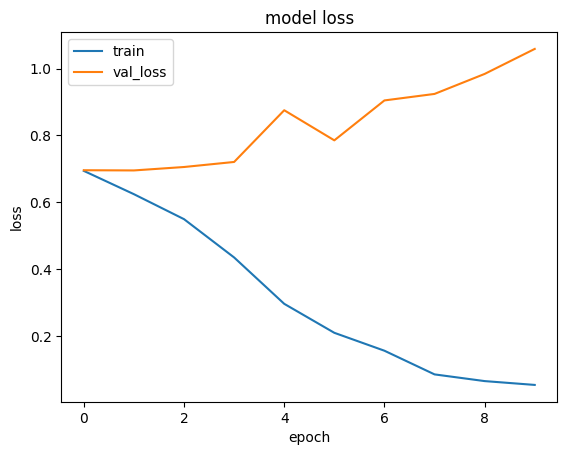

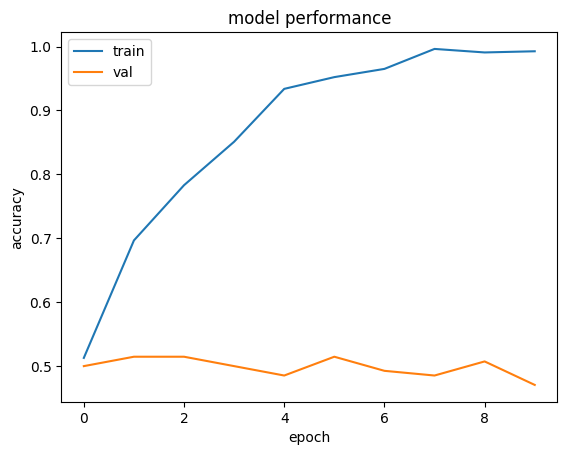

In [148]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model performance')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

Feedforwards NN

In [150]:

from tensorflow.keras.layers import  Flatten

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Text'])
sequences = tokenizer.texts_to_sequences(df['Text'])
X = pad_sequences(sequences, maxlen=max(len(x) for x in sequences))
max_sequence_length = max(len(x) for x in sequences)

# Load pre-trained GloVe embeddings (replace with the actual file path)
glove_file = 'glove.6B.300d.txt' 
embedding_dim = 300

embeddings_index = {}
with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Build the CNN model
input_layer = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_sequence_length,
                            trainable=False)(input_layer)
flat = Flatten()(embedding_layer)
dense_1 = Dense(64, activation = 'relu')(flat)
output_layer = Dense(1, activation='sigmoid')(dense_1)
model = Model(inputs=input_layer, outputs=output_layer)

learning_rate = 0.001  

custom_optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

X_train, X_test, y_train, y_test = train_test_split(X, df['Symbol'], test_size=0.2, random_state=42)

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
17/17 [==============================] - 1s 50ms/step - loss: 0.6986 - accuracy: 0.5184 - val_loss: 0.6953 - val_accuracy: 0.4926
Epoch 2/10
17/17 [==============================] - 1s 43ms/step - loss: 0.5196 - accuracy: 0.8088 - val_loss: 0.7539 - val_accuracy: 0.4779
Epoch 3/10
17/17 [==============================] - 1s 42ms/step - loss: 0.3742 - accuracy: 0.8732 - val_loss: 0.8330 - val_accuracy: 0.5000
Epoch 4/10
17/17 [==============================] - 1s 41ms/step - loss: 0.2360 - accuracy: 0.9596 - val_loss: 0.9337 - val_accuracy: 0.5000
Epoch 5/10
17/17 [==============================] - 1s 43ms/step - loss: 0.1427 - accuracy: 0.9835 - val_loss: 1.0384 - val_accuracy: 0.4853
Epoch 6/10
17/17 [==============================] - 1s 43ms/step - loss: 0.0936 - accuracy: 0.9908 - val_loss: 1.1378 - val_accuracy: 0.4926
Epoch 7/10
17/17 [==============================] - 1s 41ms/step - loss: 0.0604 - accuracy: 0.9963 - val_loss: 1.3000 - val_accuracy: 0.5294
Epoch 8/10
17

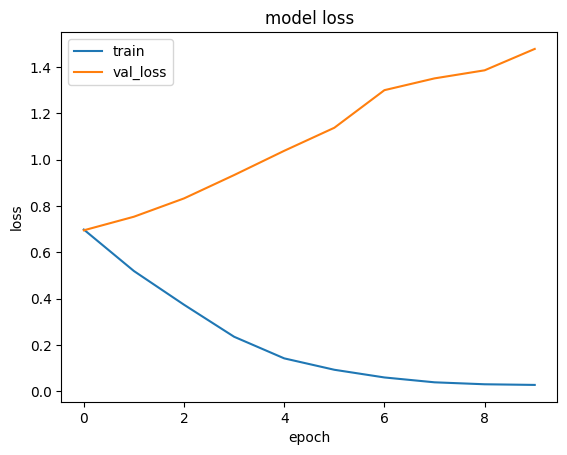

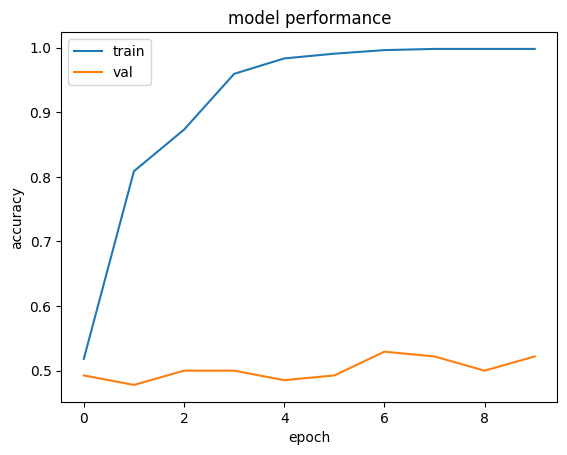

In [151]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model performance')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

LSTM

In [152]:

from tensorflow.keras.layers import LSTM, Concatenate 

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Text'])
sequences = tokenizer.texts_to_sequences(df['Text'])
X = pad_sequences(sequences, maxlen=max(len(x) for x in sequences))
max_sequence_length = max(len(x) for x in sequences)

# Load pre-trained GloVe embeddings (replace with the actual file path)
glove_file = 'glove.6B.300d.txt' 
embedding_dim = 300

embeddings_index = {}
with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Build the CNN model
input_layer = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_sequence_length,
                            trainable=False)(input_layer)
lstm_layer = LSTM(64)(embedding_layer)
output_layer = Dense(1, activation='sigmoid')(lstm_layer)
model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])


X_train, X_test, y_train, y_test = train_test_split(X, df['Symbol'], test_size=0.2, random_state=42)

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))


Epoch 1/20
17/17 [==============================] - 10s 484ms/step - loss: 0.7004 - accuracy: 0.5110 - val_loss: 0.6893 - val_accuracy: 0.5074
Epoch 2/20
17/17 [==============================] - 3s 183ms/step - loss: 0.6432 - accuracy: 0.6710 - val_loss: 0.6637 - val_accuracy: 0.5809
Epoch 3/20
17/17 [==============================] - 3s 191ms/step - loss: 0.5983 - accuracy: 0.6930 - val_loss: 0.6566 - val_accuracy: 0.5735
Epoch 4/20
17/17 [==============================] - 3s 191ms/step - loss: 0.5549 - accuracy: 0.7537 - val_loss: 0.6671 - val_accuracy: 0.6176
Epoch 5/20
17/17 [==============================] - 3s 185ms/step - loss: 0.4956 - accuracy: 0.7923 - val_loss: 0.6651 - val_accuracy: 0.5809
Epoch 6/20
17/17 [==============================] - 3s 186ms/step - loss: 0.4412 - accuracy: 0.8107 - val_loss: 0.6783 - val_accuracy: 0.5809
Epoch 7/20
17/17 [==============================] - 3s 192ms/step - loss: 0.3828 - accuracy: 0.8566 - val_loss: 0.7199 - val_accuracy: 0.5735
Epoch

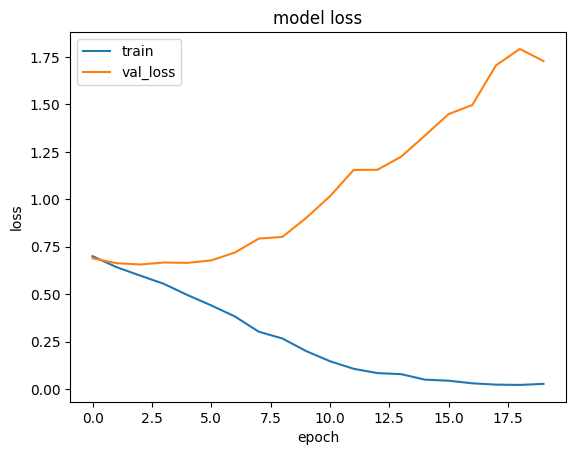

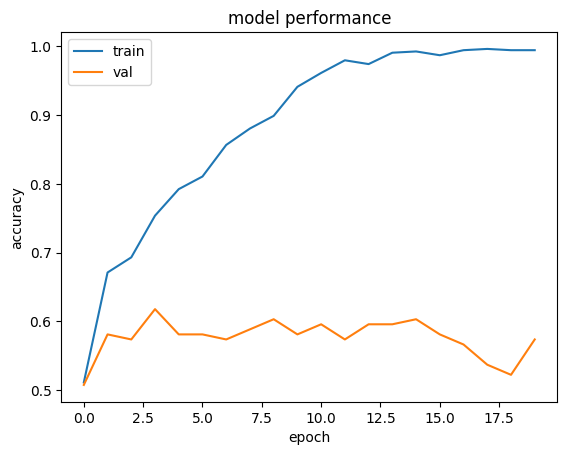

In [153]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model performance')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

LSTM + CNN

In [154]:


tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Text'])
sequences = tokenizer.texts_to_sequences(df['Text'])
X = pad_sequences(sequences, maxlen=max(len(x) for x in sequences))
max_sequence_length = max(len(x) for x in sequences)

# Load pre-trained GloVe embeddings (replace with the actual file path)
glove_file = 'glove.6B.300d.txt' 
embedding_dim = 300

embeddings_index = {}
with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


input_layer = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_sequence_length,
                            trainable=False)(input_layer)
lstm_layer = LSTM(64)(embedding_layer)
conv_layer = Conv1D(128, 5, activation='relu')(embedding_layer)
pooling_layer = GlobalMaxPooling1D()(conv_layer)
concatenated = Concatenate()([lstm_layer, pooling_layer])
output_layer = Dense(1, activation='sigmoid')(concatenated)
model = Model(inputs=input_layer, outputs=output_layer)


model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

X_train, X_test, y_train, y_test = train_test_split(X, df['Symbol'], test_size=0.2, random_state=42)

# Train the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))


Epoch 1/20
17/17 [==============================] - 5s 242ms/step - loss: 0.7049 - accuracy: 0.5331 - val_loss: 0.6371 - val_accuracy: 0.6029
Epoch 2/20
17/17 [==============================] - 3s 198ms/step - loss: 0.3930 - accuracy: 0.9044 - val_loss: 0.6237 - val_accuracy: 0.6103
Epoch 3/20
17/17 [==============================] - 3s 195ms/step - loss: 0.2625 - accuracy: 0.9706 - val_loss: 0.6271 - val_accuracy: 0.6176
Epoch 4/20
17/17 [==============================] - 3s 189ms/step - loss: 0.1781 - accuracy: 0.9926 - val_loss: 0.6766 - val_accuracy: 0.6103
Epoch 5/20
17/17 [==============================] - 3s 188ms/step - loss: 0.1266 - accuracy: 0.9963 - val_loss: 0.6515 - val_accuracy: 0.6544
Epoch 6/20
17/17 [==============================] - 3s 190ms/step - loss: 0.0872 - accuracy: 0.9982 - val_loss: 0.6785 - val_accuracy: 0.6397
Epoch 7/20
17/17 [==============================] - 3s 197ms/step - loss: 0.0650 - accuracy: 0.9982 - val_loss: 0.6846 - val_accuracy: 0.6103
Epoch 

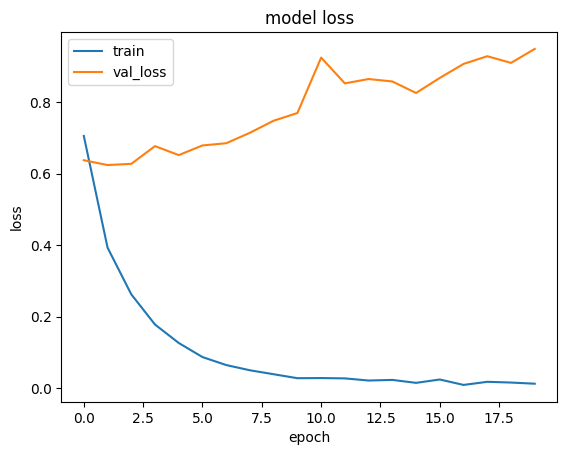

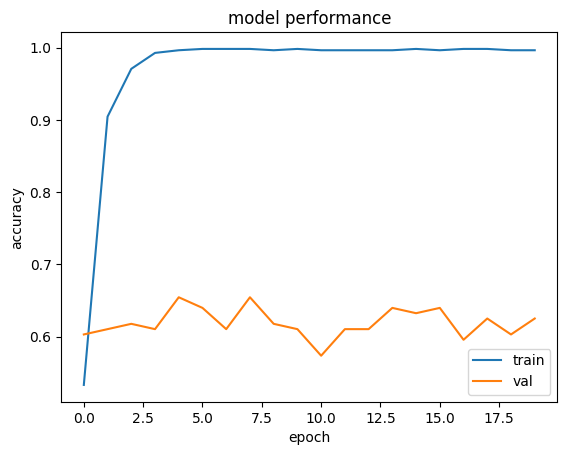

In [155]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model performance')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

Hugging face

In [3]:
from transformers import pipeline, AutoModelForTokenClassification
model_nm = 'lwachowiak/Metaphor-Detection-XLMR'

label_list= ['literal',"metaphoric"]
label_dict_relations={ i : l for i, l in enumerate(label_list) }

In [4]:
model_metaphor_detection = AutoModelForTokenClassification.from_pretrained(model_nm, id2label=label_dict_relations)

#Hugging face tokenizer:
from transformers import AutoTokenizer
tokz = AutoTokenizer.from_pretrained(model_nm)

# Change to Tensor-flow tokenizer if needed
# from tensorflow.keras.preprocessing.text import Tokenizer
# tokenizer = Tokenizer(oov_token="<OOV>")

pipeline_metaphors=pipeline("ner", model=model_metaphor_detection, tokenizer=tokz, aggregation_strategy="simple")

In [5]:
# Function to extract metaphors
def find_metaphors(text):
    entities = pipeline_metaphors(text)
    metaphoric_words = "y" if any(item['entity_group'] == "metaphoric" for item in entities) else "n"
    return metaphoric_words

# Apply the find_metaphors function to the 'Text' column
df['Metaphors'] = df['Text'].apply(find_metaphors)

# Display the DataFrame
df

,Text,Symbol,Number,Head-word,Metaphors
0,poise is a club .,y,1,poise,y
1,destroying alexandria . sunlight is silence,y,4,sunlight,y
2,feet are no anchor . gravity sucks at the mind,y,1,feet,y
3,on the day 's horizon is a gesture of earth,y,5,horizon,y
4,he said good-by as if good-by is a number .,y,6,good-by,n
...,...,...,...,...,...
675,as the season of cold is the season of darkness,n,5,cold,n
676,"else all beasts were tigers ,",y,3,beasts,n
677,without which earth is sand,n,3,earth,y
678,the sky is cloud on cloud,n,2,sky,n


In [6]:
# calculate True Positives
TP = (df['Symbol'] == 'y') & (df['Metaphors'] == 'y')
TP = TP.sum()

# calculate True Negatives
TN = (df['Symbol'] == 'n') & (df['Metaphors'] == 'n')
TN = TN.sum()

# calculate False Positives
FP = (df['Symbol'] == 'n') & (df['Metaphors'] == 'y')
FP = FP.sum()

# calculate False Negatives
FN = (df['Symbol'] == 'y') & (df['Metaphors'] == 'n')
FN = FN.sum()

# accuracy = correctly classified instances / all instances
accuracy = (TP + TN) / df.shape[0]
formatted_accuracy = "{:.2f}%".format(accuracy * 100)

print('Accuracy:', formatted_accuracy)

Accuracy: 55.88%
